In [0]:
import os
import json
import numpy as np
from random import randrange
import zipfile


import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence

from keras import regularizers
from keras.layers import Dense, Activation, Dropout, Flatten, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 

from keras import optimizers
from keras.models import Sequential
from keras.callbacks import EarlyStopping

from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
import os, re, csv, math, codecs

import seaborn as sns
from sklearn import metrics

# 1.Load and Preprocess IMDB Data


In [0]:
with zipfile.ZipFile('drive/INFO7374_NeuralNetwork&AI/Assignment_3/data/aclImdb.zip','r') as zip_ref:
    zip_ref.extractall('')

In [0]:
import os

imdb_dir = 'aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [0]:
len(texts)

25000

In [0]:
maxlen = 100  # We will cut reviews after 100 words
training_samples = 200  # We will be training on 200 samples
validation_samples = 10000  # We will be validating on 10000 samples
max_words = 10000  # We will only consider the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train_mv = data[:training_samples]
y_train_mv = labels[:training_samples]
x_val_mv = data[training_samples: training_samples + validation_samples]
y_val_mv = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [0]:
embeddings_index = {}

with open('glove.6B.100d.txt') as f:
  for line in f:
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

# 2. Training IMDB

## 2.1 GloVe

In [0]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, weights = [embedding_matrix], trainable = False, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

# hist = model.fit(x_train_mv, y_train_mv,
#                  epochs=100,
#                  batch_size=32,
#                  validation_data=(x_val_mv, y_val_mv),
#                  callbacks=callbacks_list)
# model.save_weights('transfer_1.h5')

base_model = model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
flatten_15 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_47 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 320,065
Non-trainable params: 1,000,000
_________________________________________________________________


In [0]:
model.evaluate(x_val_mv, y_val_mv)

10000/10000 [==============================] - 1s 69us/step


[0.7317584680557251, 0.5622]

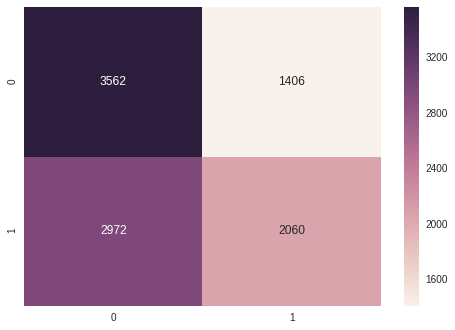

In [0]:
y_pred = model.predict(x_val_mv)
y_p = y_pred.flatten()
y_p = [1 if i > 0.5 else 0 for i in y_p]

matrix = metrics.confusion_matrix(y_val_mv, y_p)
sns.heatmap(matrix,annot=True,fmt='.5g')

In [0]:
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

optimizer = optimizers.SGD(lr=0.01, nesterov=True)

model.compile(optimizer= optimizer,
              loss='binary_crossentropy',
              metrics=['acc'])
hisT = model.fit(x_train_mv, y_train_mv,
                    epochs=200,
                    batch_size=32,
                    validation_data=(x_val_mv, y_val_mv),
                 callbacks = callbacks_list)

model.save_weights('transfer_3.h5')
base_model = model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
flatten_13 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_37 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 10000 samples
Epoch 1/200
200/200 [==============================] - 2s 10ms/step - loss: 0.6927 - acc: 0.5250 - val_loss: 0.6936 - val_acc: 0.4932
Epoch 2/200
200/200 [==============================] - 1s 3ms/step - loss: 0.6917 

In [0]:
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

optimizer = optimizers.SGD(lr=0.1, nesterov=True)

model.compile(optimizer= optimizer,
              loss='binary_crossentropy',
              metrics=['acc'])
hisT = model.fit(x_train_mv, y_train_mv,
                 epochs=200,
                 batch_size=32,
                 validation_data=(x_val_mv, y_val_mv),
                 callbacks = callbacks_list)

model.save_weights('transfer_4.h5')
base_model = model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
flatten_14 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_39 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 10000 samples
Epoch 1/200
200/200 [==============================] - 2s 10ms/step - loss: 0.6939 - acc: 0.4850 - val_loss: 0.6943 - val_acc: 0.4982
Epoch 2/200
200/200 [==============================] - 1s 3ms/step - loss: 0.6853 

## 2.2 CNN + GloVe

In [0]:
#training params
batch_size = 256 
num_epochs = 50

#model parameters
num_filters = 64 
embedding_dim = 100 
weight_decay = 1e-4

optimizer = optimizers.Adam(lr=0.001)

model = Sequential()
model.add(Embedding(max_words, embedding_dim,
          weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(1, activation='sigmoid'))  #multi-label (k-hot encoding)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

#model training
hist = model.fit(x_train_mv, 
                 y_train_mv, 
                 batch_size=batch_size, 
                 epochs=num_epochs, 
                 callbacks=callbacks_list,
                 validation_data=(x_val_mv, y_val_mv),
#                  validation_split=0.1, 
                 shuffle=True, verbose=2)

model.save_weights('transfer_cnn_1.h5')
base_model = model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 100, 64)           44864     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 50, 64)            0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 50, 64)            28736     
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 64)                0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 32)                2080      
__________

In [0]:
#training params
batch_size = 256 
num_epochs = 50

#model parameters
num_filters = 64 
embedding_dim = 100 
weight_decay = 1e-4

optimizer = optimizers.Adam(lr=0.01)

model = Sequential()
model.add(Embedding(max_words, embedding_dim,
          weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(1, activation='sigmoid'))  #multi-label (k-hot encoding)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

#model training
hist = model.fit(x_train_mv, 
                 y_train_mv, 
                 batch_size=batch_size, 
                 epochs=num_epochs, 
                 callbacks=callbacks_list,
                 validation_data=(x_val_mv, y_val_mv),
#                  validation_split=0.1, 
                 shuffle=True, verbose=2)

model.save_weights('transfer_cnn_2.h5')
base_model = model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 100, 64)           44864     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 50, 64)            0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 50, 64)            28736     
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 64)                0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 32)                2080      
__________

## 2.3 Train From Scratch - MLP

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # We will cut reviews after 100 words
training_samples = 20000  # We will be training on 200 samples
validation_samples = 5000  # We will be validating on 10000 samples
max_words = 10000  # We will only consider the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train_mv = data[:training_samples]
y_train_mv = labels[:training_samples]
x_val_mv = data[training_samples: training_samples + validation_samples]
y_val_mv = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [0]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

optimizer = optimizers.SGD(lr=0.01, nesterov=True)

model.compile(optimizer= optimizer,
              loss='binary_crossentropy',
              metrics=['acc'])
hist = model.fit(x_train_mv, y_train_mv,
                    epochs=200,
                    batch_size=32,
                    validation_data=(x_val_mv, y_val_mv),
                    callbacks=callbacks_list)

base_model = model
model.save_weights('transfer_scratch_mlp.h5')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_38 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
flatten_14 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_73 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_74 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/200
20000/20000 [==============================] - 9s 443us/step - loss: 0.6935 - acc: 0.4952 - val_loss: 0.6932 - val_acc: 0.4950
Epoch 2/200
20000/20000 [==============================] - 4s 205us/step - l

In [0]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

optimizer = optimizers.SGD(lr=0.001, nesterov=True)

model.compile(optimizer= optimizer,
              loss='binary_crossentropy',
              metrics=['acc'])
hist = model.fit(x_train_mv, y_train_mv,
                    epochs=200,
                    batch_size=32,
                    validation_data=(x_val_mv, y_val_mv),
                    callbacks=callbacks_list)

base_model = model
model.save_weights('transfer_scratch_mlp_2.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_39 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
flatten_15 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_75 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_76 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/200
20000/20000 [==============================] - 9s 470us/step - loss: 0.6931 - acc: 0.5004 - val_loss: 0.6934 - val_acc: 0.5022
Epoch 2/200
20000/20000 [==============================] - 4s 207us/step - l

In [0]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

optimizer = optimizers.Adam(lr=0.001)

model.compile(optimizer= optimizer,
              loss='binary_crossentropy',
              metrics=['acc'])
hist = model.fit(x_train_mv, y_train_mv,
                    epochs=200,
                    batch_size=32,
                    validation_data=(x_val_mv, y_val_mv),
                    callbacks=callbacks_list)

base_model = model
model.save_weights('transfer_scratch_mlp_3.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_41 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
flatten_17 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_79 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_80 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/200
20000/20000 [==============================] - 10s 513us/step - loss: 0.6938 - acc: 0.4996 - val_loss: 0.6937 - val_acc: 0.4998
Epoch 2/200
20000/20000 [==============================] - 5s 249us/step - 

## 2.4 Train From Scratch - CNN - dim100

In [0]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(1, activation='sigmoid'))  #multi-label (k-hot encoding)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

optimizer = optimizers.SGD(lr=0.01)

#model training
hist = model.fit(x_train_mv, 
                 y_train_mv, 
                 batch_size=batch_size, 
                 epochs=num_epochs, 
                 callbacks=callbacks_list,
                 validation_data=(x_val_mv, y_val_mv),
                 shuffle=True, verbose=2)

model.save_weights('transfer_scratch_cnn_0.h5')

base_model = model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_44 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
conv1d_49 (Conv1D)           (None, 100, 64)           44864     
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 50, 64)            0         
_________________________________________________________________
conv1d_50 (Conv1D)           (None, 50, 64)            28736     
_________________________________________________________________
global_max_pooling1d_25 (Glo (None, 64)                0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_85 (Dense)             (None, 32)                2080      
__________

In [0]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(1, activation='sigmoid'))  #multi-label (k-hot encoding)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

optimizer = optimizers.SGD(lr=0.001)

#model training
hist = model.fit(x_train_mv, 
                 y_train_mv, 
                 batch_size=batch_size, 
                 epochs=num_epochs, 
                 callbacks=callbacks_list,
                 validation_data=(x_val_mv, y_val_mv),
#                  validation_split=0.1, 
                 shuffle=True, verbose=2)

model.save_weights('transfer_scratch_cnn_1.h5')

base_model = model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_43 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 100, 64)           44864     
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 50, 64)            0         
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 50, 64)            28736     
_________________________________________________________________
global_max_pooling1d_24 (Glo (None, 64)                0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_83 (Dense)             (None, 32)                2080      
__________

In [0]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(1, activation='sigmoid'))  #multi-label (k-hot encoding)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

optimizer = optimizers.Adam(lr=0.001)

#model training
hist = model.fit(x_train_mv, 
                 y_train_mv, 
                 batch_size=batch_size, 
                 epochs=num_epochs, 
                 callbacks=callbacks_list,
                 validation_data=(x_val_mv, y_val_mv),
#                  validation_split=0.1, 
                 shuffle=True, verbose=2)

model.save_weights('transfer_scratch_cnn_1.h5')

base_model = model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_42 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 100, 64)           44864     
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 50, 64)            0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 50, 64)            28736     
_________________________________________________________________
global_max_pooling1d_23 (Glo (None, 64)                0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_81 (Dense)             (None, 32)                2080      
__________

# 3.Transfer Learning

## 3.1 Load Financial Data

In [0]:
def load_data(link):
  
  text = []
  sentiment = []

  for filename in os.listdir(link):
    if filename != '.ipynb_checkpoints':
      file_path = os.path.join(link, filename)
      with open(file_path, encoding = 'unicode_escape') as f:
        dic = json.load(f)

        for k, v in dic['text'].items():
          text.append(v)
        for k, v in dic['sentiment'].items():
          sentiment.append(v)
  return text, sentiment

In [0]:
def preprocess_data(text, sentiment):
  # 80-20 split
  combo = [list(i) for i in zip(text, sentiment)]
  
  combo_test = []

  test_size = int(len(combo)*0.2)
  while len(combo_test) < test_size:
    index = randrange(len(combo))
    combo_test.append(combo.pop(index))
  
  x_train = []
  y_train = []
  x_test = []
  y_test = []
  # x, y split
  for line in combo:
    x_train.append(line[0])
    if line[1] in ['Positive', 'positive', 'postive']:
      y_train.append(2)
    elif line[1] in ['Neutral', 'neutral', 'neutra', 'neutra;', 'Neural']:
      y_train.append(1)
    elif line[1] in ['Negative', 'negative', 'Negetive']:
      y_train.append(0)
    else:
      print('error in sentiment label {}'.format(line[1]))
  for line in combo_test:
    x_test.append(line[0])
    if line[1] in ['Positive', 'positive', 'postive']:
      y_test.append(2)
    elif line[1] in ['Neutral', 'neutral', 'neutra', 'neutra;', 'Neural']:
      y_test.append(1)
    elif line[1] in ['Negative', 'negative', 'Negetive']:
      y_test.append(0)
    else:
      print('error in sentiment label {}'.format(line[1]))
      
  return (x_train, y_train), (x_test, y_test)

In [0]:
link = 'drive/INFO7374_NeuralNetwork&AI/Assignment_3/data/updated-json-files'
text, sentiment = load_data(link)
(x_train, y_train), (x_test, y_test) = preprocess_data(text, sentiment)

In [0]:
# convert to one-hot encoding

from keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [0]:
len(x_train), len(x_test)

(1316, 328)

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # We will cut reviews after 100 words
training_samples = 1000  # We will be training on 200 samples
validation_samples = 316  # We will be validating on 10000 samples
max_words = 10000  # We will only consider the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)

sequences_test = tokenizer.texts_to_sequences(x_test)
x_test = pad_sequences(sequences_test, maxlen=maxlen)
y_test = np.asarray(y_test)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(y_train)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 5867 unique tokens.
Shape of data tensor: (1316, 100)
Shape of label tensor: (1316, 3)


In [0]:
base_model.load_weights('transfer_1.h5')
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
flatten_15 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_47 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 320,065
Non-trainable params: 1,000,000
_________________________________________________________________


In [0]:
model = Sequential()
for layer in base_model.layers[:-1]:
    model.add(layer)
    
for layer in model.layers:
  layer.trainable = False
  

model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
flatten_15 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_47 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_49 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_50 (Dense)             (None, 3)                 99        
Total params: 1,321,187
Trainable params: 1,155
Non-trainable params: 1,320,032
_________________________________________________________________


### 5.4 Train use Financial Data

In [0]:
optimizer = optimizers.SGD(lr=0.1)
loss = 'categorical_crossentropy'
epochs = 200
batch_size = 54

model.compile(optimizer= optimizer,
              loss = loss,
              metrics=['acc'])


In [0]:
hist = model.fit(x_train, y_train,
                 epochs=epochs,
                 batch_size=batch_size,
                 validation_split=0.2,
                 callbacks = callbacks_list
                )

Train on 800 samples, validate on 200 samples
Epoch 1/200
800/800 [==============================] - 2s 2ms/step - loss: 1.0001 - acc: 0.5275 - val_loss: 0.9965 - val_acc: 0.5600
Epoch 2/200
800/800 [==============================] - 0s 95us/step - loss: 0.9387 - acc: 0.5875 - val_loss: 0.9688 - val_acc: 0.5550
Epoch 3/200
800/800 [==============================] - 0s 92us/step - loss: 0.8961 - acc: 0.5987 - val_loss: 0.9430 - val_acc: 0.5450
Epoch 4/200
800/800 [==============================] - 0s 83us/step - loss: 0.8783 - acc: 0.6088 - val_loss: 0.9180 - val_acc: 0.5950
Epoch 5/200
800/800 [==============================] - 0s 103us/step - loss: 0.8558 - acc: 0.6100 - val_loss: 0.9093 - val_acc: 0.5850
Epoch 6/200
800/800 [==============================] - 0s 94us/step - loss: 0.8490 - acc: 0.5950 - val_loss: 0.8969 - val_acc: 0.6100
Epoch 7/200
800/800 [==============================] - 0s 98us/step - loss: 0.8358 - acc: 0.5950 - val_loss: 0.9028 - val_acc: 0.5700
Epoch 8/200
800/

In [0]:
model.evaluate(x_test, y_test)

328/328 [==============================] - 0s 89us/step


[0.8400967150199704, 0.573170731707317]

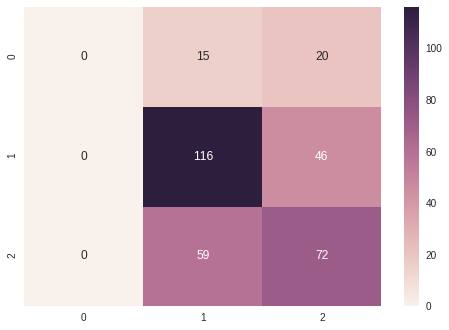

In [0]:
import seaborn as sns
from sklearn import metrics

y_pred = model.predict(x_test)
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(matrix,annot=True,fmt='.5g')

In [0]:
optimizer = optimizers.Adam(lr=0.1)
loss = 'categorical_crossentropy'
epochs = 200
batch_size = 54

model.compile(optimizer= optimizer,
              loss = loss,
              metrics=['acc'])

hist = model.fit(x_train, y_train,
                 epochs=epochs,
                 batch_size=batch_size,
                 validation_data=(x_val, y_val),
                 callbacks = callbacks_list)

Train on 1000 samples, validate on 316 samples
Epoch 1/200
1000/1000 [==============================] - 2s 2ms/step - loss: 1.1388 - acc: 0.5790 - val_loss: 0.8968 - val_acc: 0.5570
Epoch 2/200
1000/1000 [==============================] - 0s 112us/step - loss: 0.8377 - acc: 0.6100 - val_loss: 0.8888 - val_acc: 0.5253
Epoch 3/200
1000/1000 [==============================] - 0s 111us/step - loss: 0.8241 - acc: 0.5940 - val_loss: 0.8954 - val_acc: 0.5222
Epoch 4/200
1000/1000 [==============================] - 0s 105us/step - loss: 0.8366 - acc: 0.5610 - val_loss: 0.9279 - val_acc: 0.4589
Epoch 5/200
1000/1000 [==============================] - 0s 120us/step - loss: 0.8284 - acc: 0.5520 - val_loss: 0.8648 - val_acc: 0.5918
Epoch 6/200
1000/1000 [==============================] - 0s 112us/step - loss: 0.8254 - acc: 0.5610 - val_loss: 0.9199 - val_acc: 0.5285
Epoch 7/200
1000/1000 [==============================] - 0s 108us/step - loss: 0.8151 - acc: 0.5610 - val_loss: 0.8688 - val_acc: 0.5

In [0]:
optimizer = optimizers.Adam(lr=0.01)
loss = 'categorical_crossentropy'
epochs = 200
batch_size = 54

model.compile(optimizer= optimizer,
              loss = loss,
              metrics=['acc'])

hist = model.fit(x_train, y_train,
                 epochs=epochs,
                 batch_size=batch_size,
                 validation_data=(x_val, y_val),
                 callbacks = callbacks_list)

Train on 1000 samples, validate on 316 samples
Epoch 1/200
1000/1000 [==============================] - 2s 2ms/step - loss: 0.7939 - acc: 0.5950 - val_loss: 0.8695 - val_acc: 0.5949
Epoch 2/200
1000/1000 [==============================] - 0s 142us/step - loss: 0.7876 - acc: 0.5940 - val_loss: 0.8724 - val_acc: 0.5981
Epoch 3/200
1000/1000 [==============================] - 0s 110us/step - loss: 0.7848 - acc: 0.5970 - val_loss: 0.8774 - val_acc: 0.5981
Epoch 4/200
1000/1000 [==============================] - 0s 114us/step - loss: 0.7839 - acc: 0.5980 - val_loss: 0.8771 - val_acc: 0.5981
Epoch 5/200
1000/1000 [==============================] - 0s 110us/step - loss: 0.7817 - acc: 0.5980 - val_loss: 0.8819 - val_acc: 0.5981
Epoch 00005: early stopping


In [0]:
optimizer = optimizers.Adam(lr=0.001)
loss = 'categorical_crossentropy'
epochs = 200
batch_size = 54

model.compile(optimizer= optimizer,
              loss = loss,
              metrics=['acc'])

hist = model.fit(x_train, y_train,
                 epochs=epochs,
                 batch_size=batch_size,
                 validation_data=(x_val, y_val),
                 callbacks = callbacks_list)

Train on 1000 samples, validate on 316 samples
Epoch 1/200
1000/1000 [==============================] - 2s 2ms/step - loss: 0.7803 - acc: 0.5970 - val_loss: 0.8843 - val_acc: 0.5981
Epoch 2/200
1000/1000 [==============================] - 0s 135us/step - loss: 0.7791 - acc: 0.5980 - val_loss: 0.8835 - val_acc: 0.5981
Epoch 3/200
1000/1000 [==============================] - 0s 110us/step - loss: 0.7787 - acc: 0.5980 - val_loss: 0.8825 - val_acc: 0.5981
Epoch 4/200
1000/1000 [==============================] - 0s 112us/step - loss: 0.7784 - acc: 0.5980 - val_loss: 0.8818 - val_acc: 0.5981
Epoch 5/200
1000/1000 [==============================] - 0s 109us/step - loss: 0.7782 - acc: 0.5980 - val_loss: 0.8815 - val_acc: 0.5981
Epoch 00005: early stopping


In [0]:
model = Sequential()

# for layer in base_model.layers[:-1]:
model.add(base_model.layers[0])

for layer in model.layers:
  layer.trainable = False
  
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(3, activation='softmax'))  #multi-label (k-hot encoding)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

optimizer = optimizers.Adam(lr=0.001)

#model training
hist = model.fit(x_train, 
                 y_train, 
                 batch_size=batch_size, 
                 epochs=num_epochs, 
                 callbacks=callbacks_list,
                 validation_data=(x_val, y_val),
                 shuffle=True, verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 100, 64)           44864     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 50, 64)            0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 50, 64)            28736     
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 64)                0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 32)                2080      
__________

In [0]:
model = Sequential()

# for layer in base_model.layers[:-1]:
model.add(base_model.layers[0])

for layer in model.layers:
  layer.trainable = False
  
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(3, activation='softmax'))  #multi-label (k-hot encoding)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

optimizer = optimizers.Adam(lr=0.01)

#model training
hist = model.fit(x_train, 
                 y_train, 
                 batch_size=batch_size, 
                 epochs=num_epochs, 
                 callbacks=callbacks_list,
                 validation_data=(x_val, y_val),
                 shuffle=True, verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 100, 64)           44864     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 50, 64)            0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 50, 64)            28736     
_________________________________________________________________
global_max_pooling1d_12 (Glo (None, 64)                0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_55 (Dense)             (None, 32)                2080      
__________

In [0]:
model = Sequential()

# for layer in base_model.layers[:-1]:
model.add(base_model.layers[0])

for layer in model.layers:
  layer.trainable = False
  
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(3, activation='softmax'))  #multi-label (k-hot encoding)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

optimizer = optimizers.Adam(lr=0.1)

#model training
hist = model.fit(x_train, 
                 y_train, 
                 batch_size=batch_size, 
                 epochs=num_epochs, 
                 callbacks=callbacks_list,
                 validation_data=(x_val, y_val),
                 shuffle=True, verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 100, 64)           44864     
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 50, 64)            0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 50, 64)            28736     
_________________________________________________________________
global_max_pooling1d_13 (Glo (None, 64)                0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_57 (Dense)             (None, 32)                2080      
__________

In [0]:
model = Sequential()

# for layer in base_model.layers[:-1]:
model.add(base_model.layers[0])

for layer in model.layers:
  layer.trainable = False
  
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(3, activation='softmax'))  #multi-label (k-hot encoding)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

optimizer = optimizers.SGD(lr=0.001)

#model training
hist = model.fit(x_train, 
                 y_train, 
                 batch_size=batch_size, 
                 epochs=num_epochs, 
                 callbacks=callbacks_list,
                 validation_data=(x_val, y_val),
                 shuffle=True, verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 100, 64)           44864     
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 50, 64)            0         
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 50, 64)            28736     
_________________________________________________________________
global_max_pooling1d_17 (Glo (None, 64)                0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_65 (Dense)             (None, 32)                2080      
__________

In [0]:
model = Sequential()

# for layer in base_model.layers[:-1]:
model.add(base_model.layers[0])

for layer in model.layers:
  layer.trainable = False
  
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(3, activation='softmax'))  #multi-label (k-hot encoding)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

optimizer = optimizers.SGD(lr=0.01)

#model training
hist = model.fit(x_train, 
                 y_train, 
                 batch_size=batch_size, 
                 epochs=num_epochs, 
                 callbacks=callbacks_list,
                 validation_data=(x_val, y_val),
                 shuffle=True, verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 100, 64)           44864     
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 50, 64)            0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 50, 64)            28736     
_________________________________________________________________
global_max_pooling1d_16 (Glo (None, 64)                0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_63 (Dense)             (None, 32)                2080      
__________